## Spatial thermalization and setting velocities

### Note: Most of the code for the molecular dynamics simulations resides in /common/md.

We can exploit the fact that the $\alpha$ transition probabilities depend only on the temperature to thermalize the particle positions before we worry about the velocities. Since the potential energy will already be at equilibrium, we can distribute the particle velocities to get our desired temperature without having to worry about energy "leaking" from kinetic to potential form. This seems to take around 2000 iterations, at which point we're left with a good starting point for the cluster algorithm.

In [7]:
q_pe_every_ten = readdlm("q_pe_ten.dat")
q_pe = Gadfly.plot( x=[10:10:10000], y=q_pe_every_ten, Gadfly.Geom.line,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Potential Energy"),
Gadfly.Guide.title("Potential Energy vs. Metropolis Simulation Step for Liquid Argon"))

LoadError: Gadfly not defined
while loading In[7], in expression starting on line 2

In [12]:
qtherm = loadmdtrial("q1/qtherm.mdv")
qstart = subtrial(qtherm, 2000, 2000)
save("qstart.mdv", qstart)

Loading trial from q1/qtherm.mdv... done.
Saving trial as qstart.mdv... done.


## 1. Monte Carlo Simulations for Liquid Argon

### Repeat measurements from Problem Set 2

As in problem set 2, we can determine the temperature using

$$
  KE = \frac{f}{2}T = \frac{3N}{2}T
$$

and pressure (in natural units) using

$$
  \frac{p}{\rho k T} = 1 + \frac{1}{6NkT}
  \Bigg \langle \sum_{i} \sum_{j \neq i} \vec{r}_{ij} \frac{\partial V_{ij}}{\partial r_{ij}} \Bigg \rangle,
$$

where summation term is the virial.

I didn't recalculate Verlet's temperature here because I wasn't able to get it working any better than on the other set. The method is fine, but my data is still clearly a bit off. Also, I didn't bother computing velocities as part of the Verlet step, since that amounts to using a canonical argument to describe a microcanonical ensemble which is in turn used to justify the canonical predictions, a setup that seems pretty masturbatory, and anywy doesn't provide information we're interested in.

### Include statistical error for results

Again, since my energy calculations are off, I didn't get around to doing jacknife calculations for error. The approach is exactly the same as in problem set 3, though.

## 2. Cluster Algorithm for the 2d Ising Model

The source code is in Julia. The random number generator is the Mersenne Twister rather than rand3.C. The algorithm is a modified version of cluster.C, with the (formerly constant) flip probability replaced by the formula

$$
  p = 1 - e^{-2J/T}.
$$

The plots below show magnetization vs. temperature at various values of external magnetic field. In each case, several different grid sizes are used in order to guage the effect of finite lattice size on magnetization. We expect that, in the large grid, small magnetic field limit, the simulation behavior will converge to the theoretical result.

In [2]:
include("configure.jl")

steps = 20000 => 20000
Critical temperature Tc = 2.269185280793525
Importing Gadfly... done.


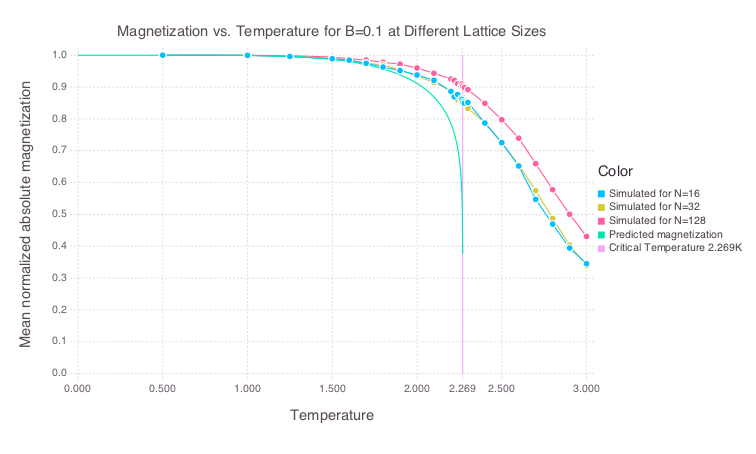

In [3]:
plots[5]

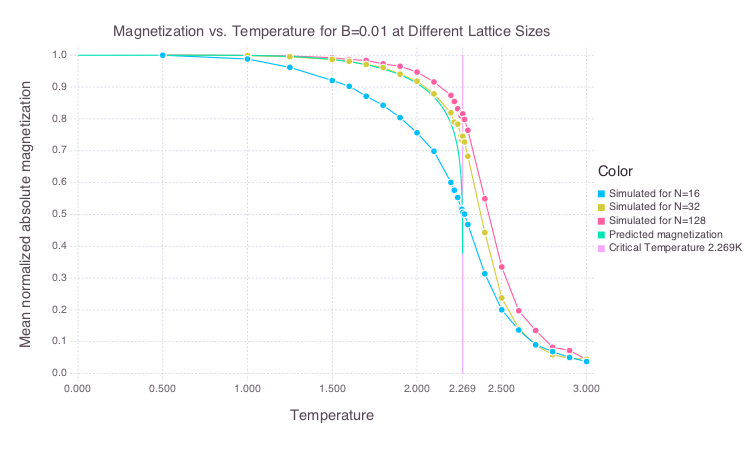

In [4]:
plots[4]

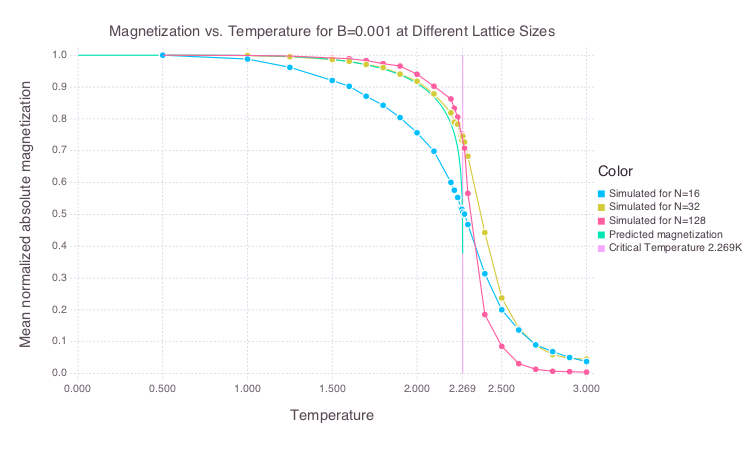

In [5]:
plots[3]

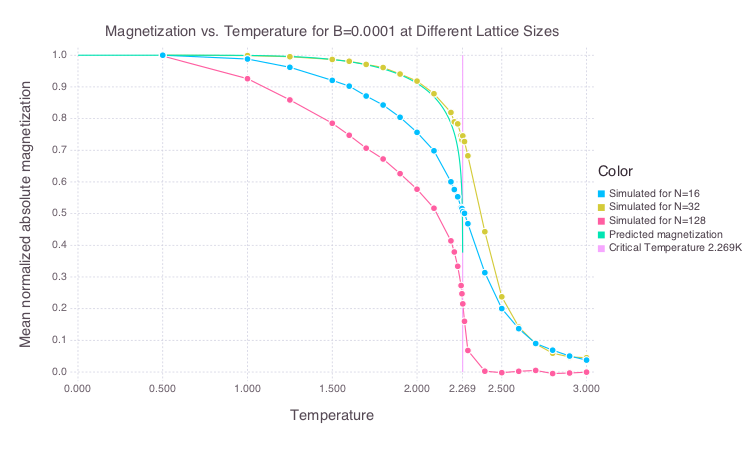

In [6]:
plots[2]

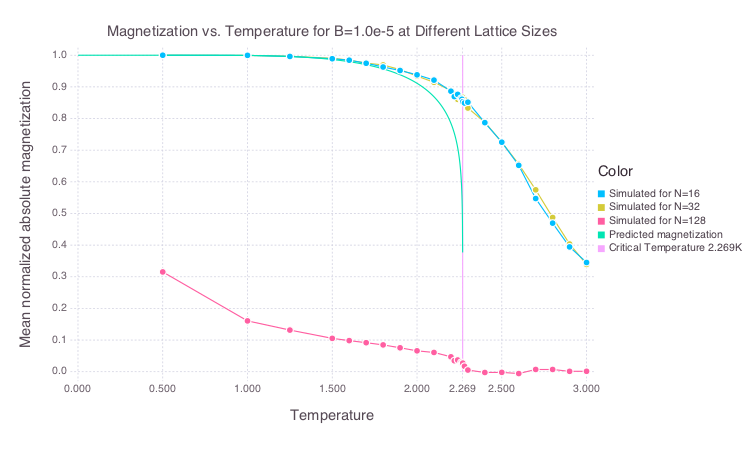

In [7]:
plots[1]

Judging by looks alone, $B=0.001$, $N=128$, though not the weakest magnetic field, provides the best agreement with theoretical values. This isn't as strange as it might at first appear, though. The cluster algorithm is inherently nonphysical and is explicitly designed to negate the metastability of positive and negative branches of the magnetization solution. Since a weak magnetic field provides only a slight energy difference between the two branches, it follows quite naturally that the cluster algorithm's rapid explorations of phase space will only slightly favor one direction. When we look at the __absolute__ magnitudes, we get much better agreement with the predicted values. This, too, makes sense, since the Hamiltonian (sans external magnetic field) is perfectly symmetric under $\sigma \rightarrow -\sigma$. Consequently, a proposed spin configuration and its exact opposite are equally likely to be accepted (again, with $B=0$). This means that the magnitude of the magnetization ignores the effect of flopping from one branch to the other.

In my opinion, this is a much more meaningful quantity for us to look at, since it takes advantage of a symmetry in the problem to give clearer results. Note also that, because we're only interested in absolute magnetism in the below graphs, the tendency of the cluster algorithm to switch from one branch to the other does not interfere with the results because it has no effect on the _absolute value_ of the magnetization. Looking at the signed magnetic field would, in a physically accurate simulation, tell us directly about the metastability of each branch, but it is of no special use to us for the cluster algorithm because it is highly nonphysical to begin with.

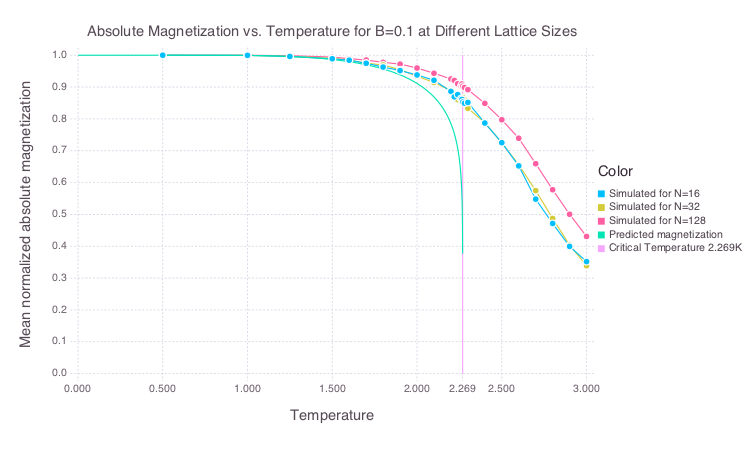

In [8]:
absplots[5]

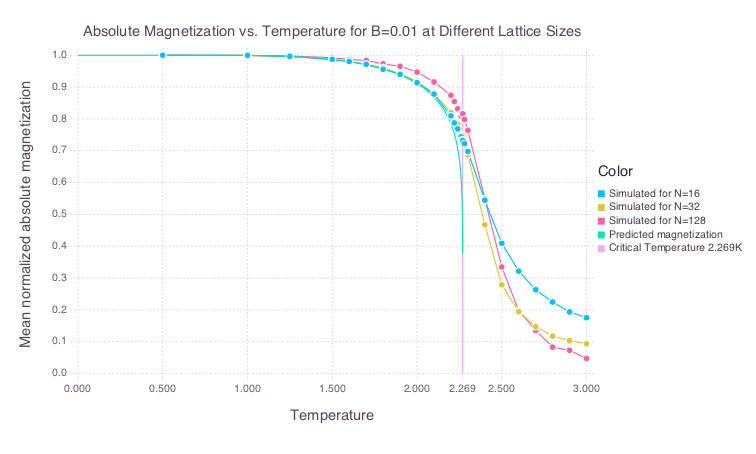

In [9]:
absplots[4]

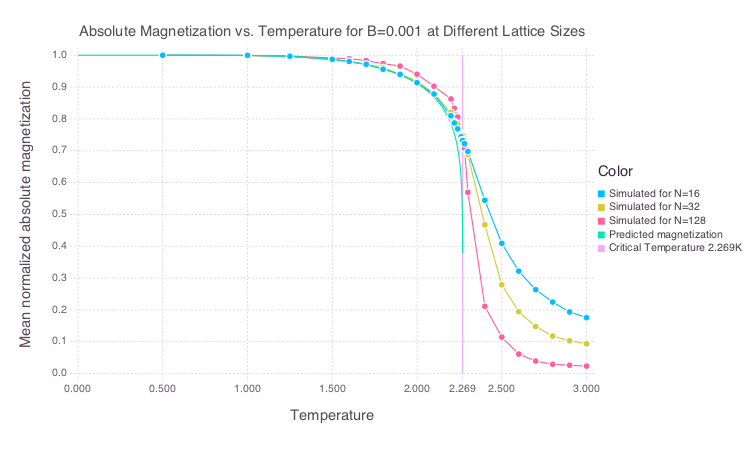

In [10]:
absplots[3]

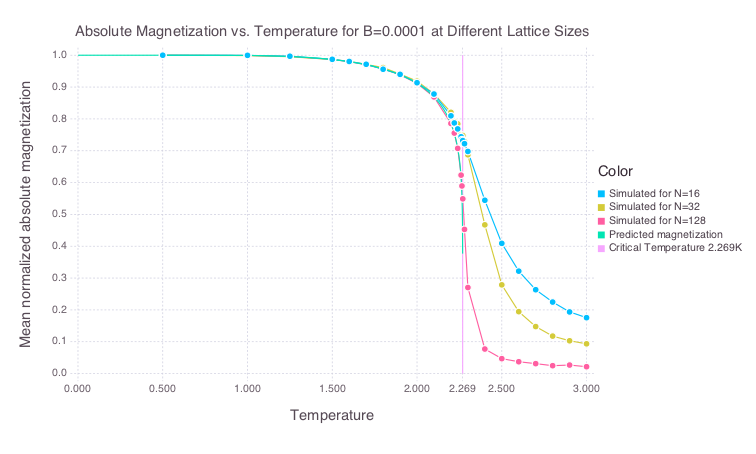

In [11]:
absplots[2]

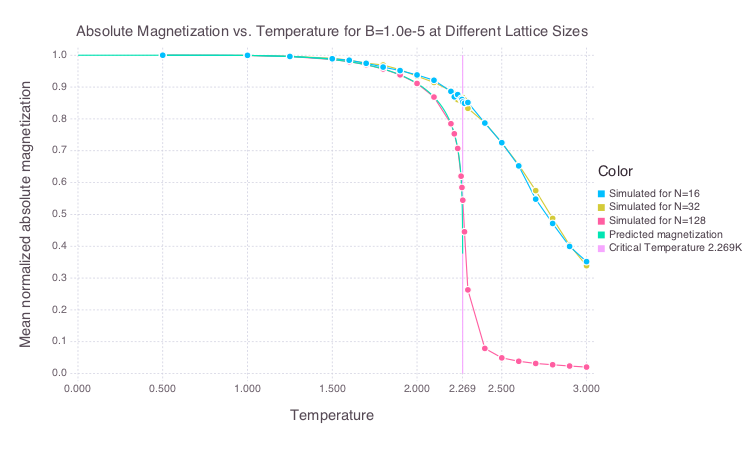

In [12]:
absplots[1]

The fit on the last one is superb. For the magnitudes of the fields, the dependence of the simulation's accuracy on both grid size and external field is made extremely clear. For the smallest external field $B=0.00001$, on a $128 \times 128$ lattice, the simulated results are quite remarkably close to the theoretical prediction.

The simulation results for very weak fields are clearly in agreement with the predicted values, with no noticeable divergence at temperatures of up to 2.265K (for reference, the critical temperature, for our chosen interaction energy, $J = 1K$, is just over 2.269K). Further improvements for temperatures approaching $ T_{C} $ are possible given larger lattices and longer thermalization times (see below), but a 128 x 128 square lattice with N=20,000 trials were in excellent agreement with predicted values for temperatures not exceedingly close to $ T_{C} $. Perhaps more importantly, the range of $ T $ values over which the simulation was innacurate shrank monotonically in the large volume limit.

Small latices $(n=16)$ behaved well, showing excellent agreement with the predicted magnetization at temperatures of up to 2.2K.

Using larger lattices for the simulations proved helpful. At $T = 2.269K, B = 0.001$ (where the simulation for $n = 16$ diverged most greatly from the predicted magnetization), increases in lattice size led directly to improved correspondence between theory and simulation:

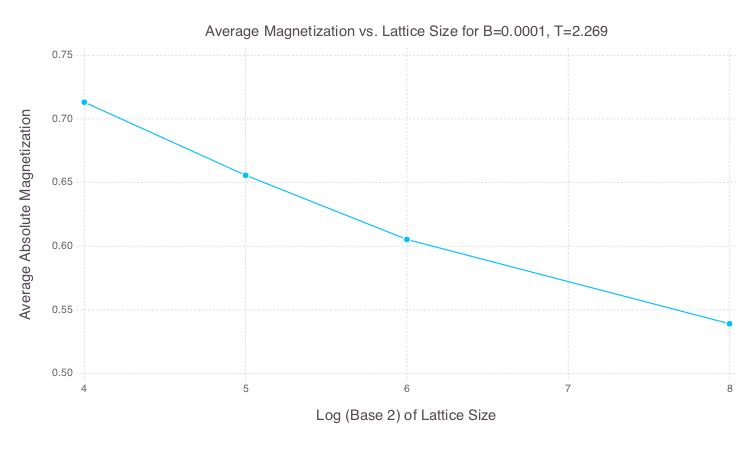

In [21]:
Gadfly.plot(Gadfly.Guide.title("Average Magnetization vs. Lattice Size for B=0.0001, T=2.269"),
Gadfly.Guide.xlabel("Log (Base 2) of Lattice Size"),
Gadfly.Guide.ylabel("Average Absolute Magnetization"),
x=[4,5,6,8], y=[0.7131, 0.6557, 0.6053, 0.5391], Gadfly.Geom.point, Gadfly.Geom.line)

For reference, the theoretically predicted magnetization for T=2.269, B=0, n approaches infinity is given by

$$
  \bigg(1 - {sinh}^{-4}\bigg(\frac{2J}{T}\bigg) \bigg)^{1/8}
$$

which equals 0.3769:

In [11]:
M(2.269,1)

0.376889226422019

Clearly, the entire phase-space has been poorly explored; the Magnetization histogram should be perfectly symmetrical in the large-N limit. Smaller lattices displayed symmetrical histograms for N=20,000, suggesting that more thermalization time is needed at n=256.

## 3. Correlations

For starters, compute $\langle \sigma ( \vec{x} ) \sigma ( \vec{y} ) \rangle$ where $\vec{x} - \vec{y} \in \{m\hat{x}, m\hat{y}\}$ for each step in a trial and save the output.

Call the correlator distance $ d \equiv | \vec{x} - \vec{y} | $. Call the correlator $ C(d) $. Apparently,

$$
  C(d) \approx e^{-\frac{d}{a(T)}}.
$$

We can interpret C(d) to be the probability density function for how far a cluster will extend in any given direction. It's expected value, $a(T)$, should be a decent estimator of cluster radius. We can solve for $a(T)$ by minimizing $\chi^2$:

So 

In [1]:
cormeans = readdlm("cormeans")
corstddevs = readdlm("corstddevs")

12x6 Array{Float64,2}:
 0.127408  0.14285   0.174526  0.171257  0.176483  0.177006
 0.188437  0.222585  0.274781  0.266979  0.27768   0.28662 
 0.225252  0.273624  0.341525  0.33211   0.346307  0.35716 
 0.247206  0.309849  0.389606  0.378713  0.396306  0.412279
 0.260388  0.334617  0.429037  0.414506  0.431657  0.450045
 0.268983  0.351746  0.454688  0.437723  0.456868  0.475263
 0.273527  0.362858  0.468915  0.452025  0.474897  0.494318
 0.277012  0.367603  0.475148  0.45954   0.482506  0.504011
 0.273527  0.362858  0.468915  0.452025  0.474897  0.494318
 0.268983  0.351746  0.454688  0.437723  0.456868  0.475263
 0.260388  0.334617  0.429037  0.414506  0.431657  0.450045
 0.247206  0.309849  0.389606  0.378713  0.396306  0.412279